# Normalized Robinson-Foulds distance to reference tree (WoL2)

In [1]:
import sys, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from warnings import simplefilter
simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)

In [3]:
import dendropy
from dendropy.calculate.treecompare import unweighted_robinson_foulds_distance, weighted_robinson_foulds_distance

In [4]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Functions

In [5]:
def get_cmap_colors(cmap_name, n):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [6]:
def shared_taxa(tree1, tree2):
    taxa1 = {node.taxon.label for node in tree1.leaf_node_iter()}
    taxa2 = {node.taxon.label for node in tree2.leaf_node_iter()}
    return list(taxa1.intersection(taxa2)), taxa1, taxa2

In [7]:
def count_internal_branches(tree):
    """
    Calculate the number of internal branches in a phylogenetic tree.

    Parameters
    ----------
    tree : dendropy.Tree
        A phylogenetic tree represented by a dendropy Tree object.

    Returns
    -------
    int
        The number of internal branches (edges) in the tree.
    """
    # Internal branches are the edges between internal nodes
    internal_branches = 0
    
    for edge in tree.postorder_edge_iter():
        if not edge.is_leaf() and edge.tail_node is not None:  # Check if it's an internal branch
            internal_branches += 1
    
    return internal_branches

In [8]:
def RF_distance(treeA, treeB, norm = True, **kwargs):
    
    treeA_copy, treeB_copy = dendropy.Tree(treeA), dendropy.Tree(treeB)
    
    # Prune trees such that they contain the same taxa, otherwise RF is much larger
    taxa_to_keep, taxa1, taxa2 = shared_taxa(treeA_copy, treeB_copy)
    if len(taxa_to_keep) < len(taxa1) or len(taxa_to_keep) < len(taxa2):
        treeA_copy.retain_taxa_with_labels(taxa_to_keep)
        treeB_copy.retain_taxa_with_labels(taxa_to_keep)
        
    # Update bipartition
    treeA_copy.update_bipartitions()
    treeB_copy.update_bipartitions()
    
    # Assuming trees share the same taxon name space
    rf = unweighted_robinson_foulds_distance(treeA_copy, treeB_copy)
    if norm:
        # Normalize by the maximal possible distance: which is the sum of internal branches
        # between both trees. Alternatively, if both trees are unrooted and binary, the sum
        # is always 2n - 6, where n is the number of tips in the tree.
        # max_dist = 2 * len(taxa_to_keep) - 6
        # Number of internal branches
        n, m = count_internal_branches(treeA_copy), count_internal_branches(treeB_copy)
        if len(taxa_to_keep) > 3:
            rf = rf / (n + m)
        else:
            rf = 0.0

    # Ratio between species in inferred to actual species tree
    ratio_sps = len(taxa2) / len(taxa1)
    
    return rf

Genomes

In [9]:
genomes = np.loadtxt(f'./input_data/genomes_sampled_family_10.txt', dtype = str)
genomes.shape

(1510,)

# Normalized Robinson-Foulds distance to reference phylogeny (WoL2)

Load data

### Marker genes selected with our approach--KEGG

In [10]:
taxon_namespace = dendropy.TaxonNamespace()
ks = [10, 50, 100, 200, 400, 600, 800, 1000]
ps = [0]
matrix = 'presence_absence_copies'
threshold = 1.0
version = 2
taxon_namespace = dendropy.TaxonNamespace()

In [11]:
%%time
trees_kegg_min = {}
for k in ks:
    for p in ps:
        combination = f'k_{k}_p_{p}/{matrix}'
        dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/min_marker_genes_per_genome/{combination}'
        trees_kegg_min[f'k_{k}_p_{p}_{matrix}'] = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk',
                                                                            schema = 'newick', taxon_namespace = taxon_namespace)

CPU times: user 596 ms, sys: 12.8 ms, total: 608 ms
Wall time: 613 ms


In [12]:
%%time
trees_kegg_no_min = {}
for k in ks:
    for p in ps:
        combination = f'k_{k}_p_{p}/{matrix}'
        dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/no_min_marker_genes_per_genome/{combination}'
        trees_kegg_no_min[f'k_{k}_p_{p}_{matrix}'] = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk',
                                                                            schema = 'newick', taxon_namespace = taxon_namespace)

CPU times: user 569 ms, sys: 12.8 ms, total: 582 ms
Wall time: 584 ms


### Marker genes selected with our approach--EggNog

In [13]:
ks = [10, 50, 100, 200, 400, 600, 800, 1000]
ps = [0]
matrix = 'presence_absence_copies'
threshold = 1.0

In [14]:
%%time
trees_eggnog_min = {}
for k in ks:
    for p in ps:
        combination = f'k_{k}_p_{p}/{matrix}'
        dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/min_marker_genes_per_genome/{combination}'
        trees_eggnog_min[f'k_{k}_p_{p}_{matrix}'] = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk',
                                                                            schema = 'newick', taxon_namespace = taxon_namespace)

CPU times: user 680 ms, sys: 11.6 ms, total: 691 ms
Wall time: 695 ms


In [15]:
%%time
trees_eggnog_no_min = {}
for k in ks:
    for p in ps:
        combination = f'k_{k}_p_{p}/{matrix}'
        dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/no_min_marker_genes_per_genome/{combination}'
        trees_eggnog_no_min[f'k_{k}_p_{p}_{matrix}'] = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk',
                                                                            schema = 'newick', taxon_namespace = taxon_namespace)

CPU times: user 608 ms, sys: 10.9 ms, total: 619 ms
Wall time: 621 ms


### WoL2: reference tree. Available from [WoL2 FTP server](http://ftp.microbio.me/pub/wol2/phylogeny/)

In [16]:
tree_wol_dendro = dendropy.Tree.get(path = f'./input_data/tree.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

Prune tree

In [17]:
tree_wol_dendro.retain_taxa_with_labels(genomes)
# Update bipartition
tree_wol_dendro.update_bipartitions()

### 41 SCG from Martinez-Gutierrez

In [18]:
dataPathIn = f'./input_data/wol2/martinez_gutierrez/wol2'
tree_martinez = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

### 57 SCG from Moody 2024

In [19]:
dataPathIn = f'./input_data/wol2/moody/wol2'
tree_moody = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

### 400 SCG from Phylophlan3

In [20]:
dataPathIn = f'./input_data/wol2/phylophlan/wol2_min_marker_genes_per_genome_100'
tree_phylophlan_min = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [21]:
dataPathIn = f'./input_data/wol2/phylophlan/wol2_min_marker_genes_per_genome_1'
tree_phylophlan_no_min = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

### 136 SCG from Amphora2

In [22]:
dataPathIn = f'./input_data/wol2/amphora2/wol2_min_marker_genes_per_genome_34'
tree_amphora_min = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [23]:
dataPathIn = f'./input_data/wol2/amphora2/wol2_min_marker_genes_per_genome_1'
tree_amphora_no_min = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

# normalized Robinson Foulds distance

In [24]:
%%time
distances_trees_min = {}
distances_trees_no_min = {}
p, matrix = 0, 'presence_absence_copies'

# PFAM*, KEGG, and EggNog
for k in ks:
    distances_trees_min[f'kegg_k_{k}_p_{p}'] = RF_distance(trees_kegg_min[f'k_{k}_p_{p}_{matrix}'], tree_wol_dendro)
    distances_trees_min[f'eggnog_k_{k}_p_{p}'] = RF_distance(trees_eggnog_min[f'k_{k}_p_{p}_{matrix}'], tree_wol_dendro)
    distances_trees_no_min[f'kegg_k_{k}_p_{p}'] = RF_distance(trees_kegg_no_min[f'k_{k}_p_{p}_{matrix}'], tree_wol_dendro)
    distances_trees_no_min[f'eggnog_k_{k}_p_{p}'] = RF_distance(trees_eggnog_no_min[f'k_{k}_p_{p}_{matrix}'], tree_wol_dendro)

# Other marker gene sets
distances_trees_min['martinez'] = RF_distance(tree_martinez, tree_wol_dendro)
distances_trees_min['moody'] = RF_distance(tree_moody, tree_wol_dendro)
distances_trees_min['phylophlan'] = RF_distance(tree_phylophlan_min, tree_wol_dendro)
distances_trees_min['amphora'] = RF_distance(tree_amphora_min, tree_wol_dendro)

distances_trees_no_min['martinez'] = RF_distance(tree_martinez, tree_wol_dendro)
distances_trees_no_min['moody'] = RF_distance(tree_moody, tree_wol_dendro)
distances_trees_no_min['phylophlan'] = RF_distance(tree_phylophlan_no_min, tree_wol_dendro)
distances_trees_no_min['amphora'] = RF_distance(tree_amphora_no_min, tree_wol_dendro)

CPU times: user 1min 55s, sys: 571 ms, total: 1min 56s
Wall time: 1min 56s


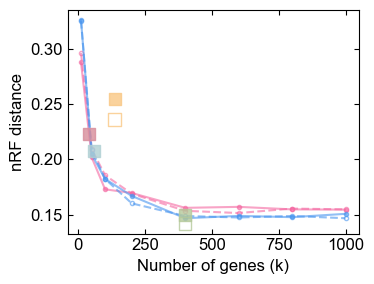

In [25]:
p, matrix = 0, 'presence_absence_copies'
plt.figure(figsize = (3.9, 3))

# KEGG
y_kegg_min = []
y_kegg_no_min = []
for k in ks:
    y_kegg_min.append(distances_trees_min[f'kegg_k_{k}_p_{p}'])
    y_kegg_no_min.append(distances_trees_no_min[f'kegg_k_{k}_p_{p}'])
plt.plot(ks, y_kegg_min, color = '#f467a1', alpha = 0.6, marker = '.', label = f'KEGG')
plt.plot(ks, y_kegg_no_min, color = '#f467a1', alpha = 0.6, marker = '.', ls = 'dashed',
        markerfacecolor = 'none')

# Eggnog
y_eggnog_min = []
y_eggnog_no_min = []
for k in ks:
    y_eggnog_min.append(distances_trees_min[f'eggnog_k_{k}_p_{p}'])
    y_eggnog_no_min.append(distances_trees_no_min[f'eggnog_k_{k}_p_{p}'])
plt.plot(ks, y_eggnog_min, color = '#4895ef', alpha = 0.6, marker = '.', label = f'EggNog')
plt.plot(ks, y_eggnog_no_min, color = '#4895ef', alpha = 0.6, marker = '.', ls = 'dashed',
        markerfacecolor = 'none')

plt.scatter(41, distances_trees_min['martinez'], color = '#d88c9a', marker = 's', alpha = 0.8, label = 'Martinez',
            s = 80, zorder = 2)
plt.scatter(57, distances_trees_min['moody'], color = '#b0d0d3', marker = 's', alpha = 0.8, label = 'Moody',
            s = 80, zorder = 2)
plt.scatter(400, distances_trees_min['phylophlan'], color = '#b5c99a', marker = 's', alpha = 0.8, label = 'Phylophlan3',
            s = 80, zorder = 2)
plt.scatter(136, distances_trees_min['amphora'], color = '#f9c784', marker = 's', alpha = 0.8, label = 'Amphora2',
            s = 80, zorder = 2)

plt.scatter(400, distances_trees_no_min['phylophlan'], color = '#b5c99a', marker = 's', alpha = 0.8, facecolor = 'none',
            s = 80, zorder = 2)
plt.scatter(136, distances_trees_no_min['amphora'], color = '#f9c784', marker = 's', alpha = 0.8, facecolor = 'none',
            s = 80, zorder = 2)

# plt.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
plt.xlabel('Number of genes (k)')
plt.ylabel('nRF distance')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
# plt.ylim(0.1, 0.25)
plt.savefig(f'./figures/figure_3B.svg')
plt.show()

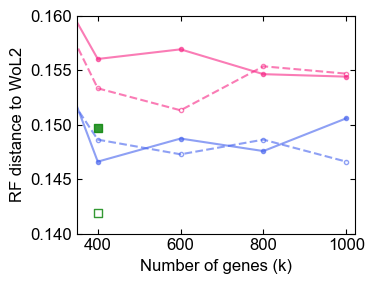

In [26]:
p, matrix = 0, 'presence_absence_copies'
plt.figure(figsize = (3.9, 3))

# KEGG
y_kegg_min = []
y_kegg_no_min = []
for k in ks:
    y_kegg_min.append(distances_trees_min[f'kegg_k_{k}_p_{p}'])
    y_kegg_no_min.append(distances_trees_no_min[f'kegg_k_{k}_p_{p}'])
plt.plot(ks, y_kegg_min, color = '#f72585', alpha = 0.6, marker = '.', label = f'KEGG')
plt.plot(ks, y_kegg_no_min, color = '#f72585', alpha = 0.6, marker = '.', ls = 'dashed',
        markerfacecolor = 'none')

# Eggnog
y_eggnog_min = []
y_eggnog_no_min = []
for k in ks:
    y_eggnog_min.append(distances_trees_min[f'eggnog_k_{k}_p_{p}'])
    y_eggnog_no_min.append(distances_trees_no_min[f'eggnog_k_{k}_p_{p}'])
plt.plot(ks, y_eggnog_min, color = '#4361ee', alpha = 0.6, marker = '.', label = f'EggNog')
plt.plot(ks, y_eggnog_no_min, color = '#4361ee', alpha = 0.6, marker = '.', ls = 'dashed',
        markerfacecolor = 'none')

plt.scatter(41, distances_trees_min['martinez'], color = 'r', marker = 's', alpha = 0.8, label = 'Martinez')
plt.scatter(57, distances_trees_min['moody'], color = 'b', marker = 's', alpha = 0.8, label = 'Moody')
plt.scatter(400, distances_trees_min['phylophlan'], color = 'g', marker = 's', alpha = 0.8, label = 'Phylophlan3')
plt.scatter(136, distances_trees_min['amphora'], color = 'orange', marker = 's', alpha = 0.8, label = 'Amphora2')

plt.scatter(400, distances_trees_no_min['phylophlan'], color = 'g', marker = 's', alpha = 0.8, facecolor = 'none')

plt.scatter(136, distances_trees_no_min['amphora'], color = 'orange', marker = 's', alpha = 0.8, facecolor = 'none')

# plt.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
plt.xlabel('Number of genes (k)')
plt.ylabel('RF distance to WoL2')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylim(0.14, 0.16)
plt.xlim(350, 1020)
# plt.savefig(f'./figures/figure_3B_inset.svg')
plt.show()

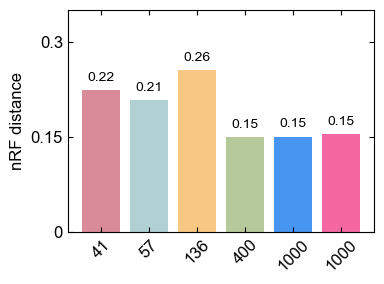

In [27]:
# Barplot
k = 1000
p = 0
x = np.arange(6)
colors = ['#d88c9a', '#b0d0d3', '#f9c784', '#b5c99a', '#4895ef', '#f467a1']

data_barplot = [distances_trees_min['martinez'], distances_trees_min['moody'],
            distances_trees_min['amphora'], distances_trees_min['phylophlan'],
            distances_trees_min[f'eggnog_k_{k}_p_{p}'], distances_trees_min[f'kegg_k_{k}_p_{p}']]

plt.figure(figsize = (4, 3))
plt.bar(x, data_barplot, color = colors)
# Add text annotation on top of bars
for i, v in enumerate(data_barplot):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xticks(x, labels = ['41', '57', '136', '400', '1000', '1000'], rotation = 45, ha='center')
# Cutomize y axis ticks labels
plt.yticks([0, 0.15, 0.3], [0, 0.15, 0.3])
plt.ylim(0.0, 0.35)
plt.ylabel('nRF distance')
plt.savefig(f'./figures/figure_3B_inset.svg')
plt.show()

Alternative visualization

In [28]:
# Data
p = 0
ks_previous = [41, 57, 136, 400]
nrf_previous_min = [distances_trees_min['martinez'], distances_trees_min['moody'],
            distances_trees_min['amphora'], distances_trees_min['phylophlan']]
nrf_previous_no_min = [distances_trees_no_min['martinez'], distances_trees_no_min['moody'],
            distances_trees_no_min['amphora'], distances_trees_no_min['phylophlan']]
ks_kegg_eggnog = [10, 50, 100, 200, 400, 600, 800, 1000]
nrf_kegg_min = []
nrf_kegg_no_min = []
nrf_eggnog_min = []
nrf_eggnog_no_min = []
for k in ks_kegg_eggnog:
    nrf_kegg_min.append(distances_trees_min[f'kegg_k_{k}_p_{p}'])
    nrf_kegg_no_min.append(distances_trees_no_min[f'kegg_k_{k}_p_{p}'])
    nrf_eggnog_min.append(distances_trees_min[f'eggnog_k_{k}_p_{p}'])
    nrf_eggnog_no_min.append(distances_trees_no_min[f'eggnog_k_{k}_p_{p}'])

/var/folders/kf/c67frc8x3_vbmg84ldmjmbkc0000gq/T/ipykernel_72229/241672316.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


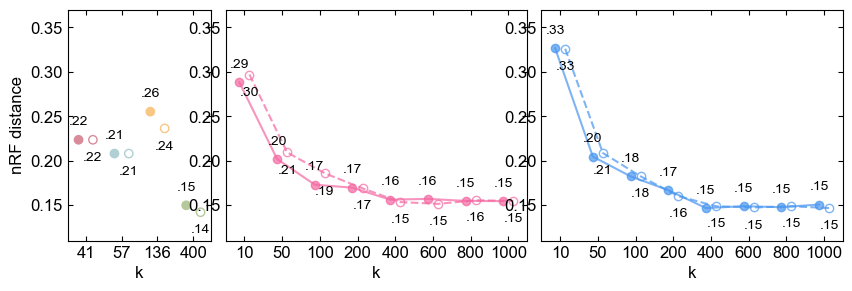

In [29]:
# Create a figure
fig = plt.figure(figsize=(10, 3))
offset = 0.4

# Define GridSpec with specific width ratios
gs = fig.add_gridspec(1, 5, width_ratios=[3, 3, 3, 3, 3], wspace = 0.1)

# Plot 1
ax0 = fig.add_subplot(gs[0, 0])
x = np.arange(4) * 2
ax0.scatter(x - offset, nrf_previous_min, color = ['#d88c9a', '#b0d0d3', '#f9c784', '#b5c99a'])
ax0.scatter(x + offset, nrf_previous_no_min, color = ['#d88c9a', '#b0d0d3', '#f9c784', '#b5c99a'],
            facecolor = 'none')
# Add text annotations
for i, xs in enumerate(x):
    ax0.text(xs - offset, nrf_previous_min[i] + 0.02, f'{nrf_previous_min[i] % 1:.2f}'[1:], 
            ha='center', va='center', fontsize=10)
    ax0.text(xs + offset, nrf_previous_no_min[i] - 0.02, f'{nrf_previous_no_min[i] % 1:.2f}'[1:],
            ha='center', va='center', fontsize=10)
ax0.set_xticks(x, ks_previous)
ax0.set_xlabel('k')
ax0.set_ylabel('nRF distance')
ax0.set_ylim(0.11, 0.37)
ax0.set_xlim(-1, 7)
ax0.tick_params(top = True, right = True, direction = 'in', which = 'both')

# Plot 2
ax1 = fig.add_subplot(gs[0, 1:3], sharey = ax0)
x = np.arange(8) * 3
ax1.plot(x - offset, nrf_kegg_min, marker = 'o', color = '#f467a1', alpha = 0.7)
ax1.plot(x + offset, nrf_kegg_no_min, marker = 'o', color = '#f467a1',
        ls = 'dashed', markerfacecolor = 'none', alpha = 0.7)
# Add text annotations
for i, xs in enumerate(x):
    ax1.text(xs - offset, nrf_kegg_min[i] + 0.02, f'{nrf_kegg_min[i] % 1:.2f}'[1:], 
            ha='center', va='center', fontsize=10)
    ax1.text(xs + offset, nrf_kegg_no_min[i] - 0.02, f'{nrf_kegg_no_min[i] % 1:.2f}'[1:],
            ha='center', va='center', fontsize=10)
ax1.set_xticks(x, ks_kegg_eggnog)
# ax1.set_yticklabels([])
ax1.set_xlabel('k')
ax1.tick_params(top = True, right = True, direction = 'in', which = 'both')

# Plot 3
ax1 = fig.add_subplot(gs[0, 3:], sharey = ax0)
x = np.arange(8) * 3
ax1.plot(x - offset, nrf_eggnog_min, marker = 'o', color = '#4895ef', alpha = 0.7)
ax1.plot(x + offset, nrf_eggnog_no_min, marker = 'o', color = '#4895ef',
        ls = 'dashed', markerfacecolor = 'none', alpha = 0.7)
# Add text annotations
for i, xs in enumerate(x):
    ax1.text(xs - offset, nrf_eggnog_min[i] + 0.02, f'{nrf_eggnog_min[i] % 1:.2f}'[1:], 
            ha='center', va='center', fontsize=10)
    ax1.text(xs + offset, nrf_eggnog_no_min[i] - 0.02, f'{nrf_eggnog_no_min[i] % 1:.2f}'[1:],
            ha='center', va='center', fontsize=10)
ax1.set_xticks(x, ks_kegg_eggnog)
# ax1.set_yticklabels([])
ax1.set_xlabel('k')
ax1.tick_params(top = True, right = True, direction = 'in', which = 'both')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(f'./figures/figure_3B_alt.svg')
plt.show()

## Impact of copy number (measured as bitscore)

In [28]:
taxon_namespace = dendropy.TaxonNamespace()
tree_wol_dendro = dendropy.Tree.get(path = f'./input_data/tree.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [29]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 1.0
version = 2
combination = f'k_{k}_p_{p}/{matrix}' 
dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/min_marker_genes_per_genome/{combination}'
tree_kegg_bs_1 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [30]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.98
dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/{combination}'
tree_kegg_bs_098 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [31]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.95
dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/{combination}'
tree_kegg_bs_095 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [32]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.9
dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/{combination}'
tree_kegg_bs_09 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [33]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.5
dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/{combination}'
tree_kegg_bs_05 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [34]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.0
dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/{combination}'
tree_kegg_bs_0 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [35]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 1.0
dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/min_marker_genes_per_genome/{combination}'
tree_eggnog_bs_1 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [36]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.98
dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/{combination}'
tree_eggnog_bs_098 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [37]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.95
dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/{combination}'
tree_eggnog_bs_095 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [38]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.9
dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/{combination}'
tree_eggnog_bs_09 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [39]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.5
dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/{combination}'
tree_eggnog_bs_05 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

In [40]:
k, p, matrix = 400, 0, 'presence_absence_copies'
threshold = 0.0
dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/{combination}'
tree_eggnog_bs_0 = dendropy.Tree.get(path = f'{dataPathIn}/lpp_astral-pro{version}.nwk', schema = 'newick', taxon_namespace = taxon_namespace)

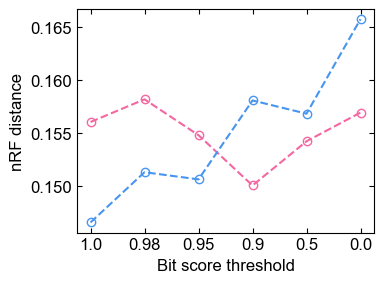

In [41]:
plt.figure(figsize = (4, 3))
y = [RF_distance(tree_kegg_bs_1, tree_wol_dendro),
     RF_distance(tree_kegg_bs_098, tree_wol_dendro),
    RF_distance(tree_kegg_bs_095, tree_wol_dendro),
     RF_distance(tree_kegg_bs_09, tree_wol_dendro),
    RF_distance(tree_kegg_bs_05, tree_wol_dendro),
    RF_distance(tree_kegg_bs_0, tree_wol_dendro)]
x = np.arange(len(y))
plt.plot(x, y, marker = 'o', color = '#f467a1', label = 'KEGG', ls = 'dashed', markerfacecolor = 'none')

y = [RF_distance(tree_eggnog_bs_1, tree_wol_dendro),
     RF_distance(tree_eggnog_bs_098, tree_wol_dendro),
    RF_distance(tree_eggnog_bs_095, tree_wol_dendro),
     RF_distance(tree_eggnog_bs_09, tree_wol_dendro),
    RF_distance(tree_eggnog_bs_05, tree_wol_dendro),
    RF_distance(tree_eggnog_bs_0, tree_wol_dendro)]
plt.plot(x, y, marker = 'o', color = '#4895ef', label = 'EggNog', ls = 'dashed', markerfacecolor = 'none')

plt.xticks(x, labels = [1.0, 0.98, 0.95, 0.9, 0.5, 0.0])

plt.xlabel('Bit score threshold')
plt.ylabel('nRF distance')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.savefig(f'./figures/figure_S3A_nrf.svg')
plt.show()